In [1]:
import numpy as np
import matplotlib.pyplot as plt

from sklearn.pipeline import Pipeline
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis
from sklearn.model_selection import ShuffleSplit, cross_val_score

from mne import Epochs, pick_types, find_events
from mne.channels import read_layout
from mne.io import concatenate_raws, read_raw_edf
from mne.datasets import eegbci
from mne.decoding import CSP

print(__doc__)

Automatically created module for IPython interactive environment


In [13]:
tmin, tmax = -1., 4.
event_id = dict(hands=2, feet=3)
subject = 1
runs = [6, 10, 14]  # motor imagery: hands vs feet
raw_fnames = eegbci.load_data(subject, runs)
raw_files = [read_raw_edf(f, preload=True, stim_channel='auto') for f in
             raw_fnames]
raw = concatenate_raws(raw_files)

Extracting EDF parameters from /home/jingyan/mne_data/MNE-eegbci-data/physiobank/database/eegmmidb/S001/S001R06.edf...
EDF file detected
EDF annotations detected (consider using raw.find_edf_events() to extract them)
Setting channel info structure...
Creating raw.info structure...
Reading 0 ... 19999  =      0.000 ...   124.994 secs...
Used Annotations descriptions: ['T0', 'T2', 'T1']
Extracting EDF parameters from /home/jingyan/mne_data/MNE-eegbci-data/physiobank/database/eegmmidb/S001/S001R10.edf...
EDF file detected
EDF annotations detected (consider using raw.find_edf_events() to extract them)
Setting channel info structure...
Creating raw.info structure...
Reading 0 ... 19999  =      0.000 ...   124.994 secs...
Used Annotations descriptions: ['T0', 'T1', 'T2']
Extracting EDF parameters from /home/jingyan/mne_data/MNE-eegbci-data/physiobank/database/eegmmidb/S001/S001R14.edf...
EDF file detected
EDF annotations detected (consider using raw.find_edf_events() to extract them)
Setting

In [26]:
raw.rename_channels(lambda x: x.strip('.'))
raw.filter(7., 30., fir_design='firwin', skip_by_annotation='edge')
events = find_events(raw, shortest_event=0, stim_channel='STI 014')
picks = pick_types(raw.info, meg=False, eeg=True, stim=False, eog=False,
                   exclude='bads')
epochs = Epochs(raw, events, event_id, tmin, tmax, proj=True, picks=picks,
                baseline=None, preload=True)
epochs_train = epochs.copy().crop(tmin=1., tmax=2.)
labels = epochs.events[:, -1] - 2

Setting up band-pass filter from 7 - 30 Hz
l_trans_bandwidth chosen to be 2.0 Hz
h_trans_bandwidth chosen to be 7.5 Hz
Filter length of 265 samples (1.656 sec) selected
Setting up band-pass filter from 7 - 30 Hz
l_trans_bandwidth chosen to be 2.0 Hz
h_trans_bandwidth chosen to be 7.5 Hz
Filter length of 265 samples (1.656 sec) selected
Setting up band-pass filter from 7 - 30 Hz
l_trans_bandwidth chosen to be 2.0 Hz
h_trans_bandwidth chosen to be 7.5 Hz
Filter length of 265 samples (1.656 sec) selected
Trigger channel has a non-zero initial value of 1 (consider using initial_event=True to detect this event)
Removing orphaned offset at the beginning of the file.
71 events found
Event IDs: [1 2 3]
45 matching events found
No baseline correction applied
Not setting metadata
0 projection items activated
Loading data for 45 events and 801 original time points ...
0 bad epochs dropped


In [92]:
scores = []
epochs_data = epochs.get_data()
epochs_data_train = epochs_train.get_data()
cv = ShuffleSplit(10, test_size=0.2, random_state=42)
cv_split = cv.split(epochs_data_train)
lda = LinearDiscriminantAnalysis()
csp = CSP(n_components=4, reg=None, log=True, norm_trace=False)

In [93]:
clf = Pipeline([('CSP', csp), ('LDA', lda)])
scores = cross_val_score(clf, epochs_data_train, labels, cv=cv, n_jobs=1)
class_balance = np.mean(labels == labels[0])
class_balance = max(class_balance, 1. - class_balance)
print("Classification accuracy: %f / Chance level: %f" % (np.mean(scores),
                                                          class_balance))

Estimating covariance using EMPIRICAL
Done.
Estimating covariance using EMPIRICAL
Done.
Estimating covariance using EMPIRICAL
Done.
Estimating covariance using EMPIRICAL
Done.
Estimating covariance using EMPIRICAL
Done.
Estimating covariance using EMPIRICAL
Done.
Estimating covariance using EMPIRICAL
Done.
Estimating covariance using EMPIRICAL
Done.
Estimating covariance using EMPIRICAL
Done.
Estimating covariance using EMPIRICAL
Done.
Estimating covariance using EMPIRICAL
Done.
Estimating covariance using EMPIRICAL
Done.
Estimating covariance using EMPIRICAL
Done.
Estimating covariance using EMPIRICAL
Done.
Estimating covariance using EMPIRICAL
Done.
Estimating covariance using EMPIRICAL
Done.
Estimating covariance using EMPIRICAL
Done.
Estimating covariance using EMPIRICAL
Done.
Estimating covariance using EMPIRICAL
Done.
Estimating covariance using EMPIRICAL
Done.
Classification accuracy: 0.944444 / Chance level: 0.533333


Estimating covariance using EMPIRICAL
Done.
Estimating covariance using EMPIRICAL
Done.


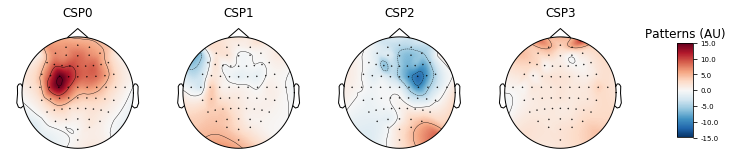

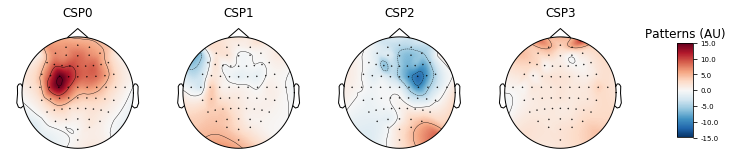

In [47]:
csp.fit_transform(epochs_data, labels)

layout = read_layout('EEG1005')
csp.plot_patterns(epochs.info, layout=layout, ch_type='eeg',
                  units='Patterns (AU)', size=1.5)

In [100]:
a=csp.fit(epochs_data_train, labels)

Estimating covariance using EMPIRICAL
Done.
Estimating covariance using EMPIRICAL
Done.


In [95]:
lda.fit(a,labels)

LinearDiscriminantAnalysis(n_components=None, priors=None, shrinkage=None,
              solver='svd', store_covariance=False, tol=0.0001)

In [96]:
b=csp.transform(epochs_data)

In [99]:
lda.score(b,labels)

0.7777777777777778

In [108]:
epochs_data_train.shape

(45, 64, 161)

In [69]:
sfreq = raw.info['sfreq']
w_length = int(sfreq * 0.5)   # running classifier: window length
w_step = int(sfreq * 0.1)  # running classifier: window step size
w_start = np.arange(0, epochs_data.shape[2] - w_length, w_step)

scores_windows = []

for train_idx, test_idx in cv_split:
    y_train, y_test = labels[train_idx], labels[test_idx]

    X_train = csp.fit_transform(epochs_data_train[train_idx], y_train)
    X_test = csp.transform(epochs_data_train[test_idx])

Estimating covariance using EMPIRICAL
Done.
Estimating covariance using EMPIRICAL
Done.
Estimating covariance using EMPIRICAL
Done.
Estimating covariance using EMPIRICAL
Done.
Estimating covariance using EMPIRICAL
Done.
Estimating covariance using EMPIRICAL
Done.
Estimating covariance using EMPIRICAL
Done.
Estimating covariance using EMPIRICAL
Done.
Estimating covariance using EMPIRICAL
Done.
Estimating covariance using EMPIRICAL
Done.
Estimating covariance using EMPIRICAL
Done.
Estimating covariance using EMPIRICAL
Done.
Estimating covariance using EMPIRICAL
Done.
Estimating covariance using EMPIRICAL
Done.
Estimating covariance using EMPIRICAL
Done.
Estimating covariance using EMPIRICAL
Done.
Estimating covariance using EMPIRICAL
Done.
Estimating covariance using EMPIRICAL
Done.
Estimating covariance using EMPIRICAL
Done.
Estimating covariance using EMPIRICAL
Done.


In [77]:
csp.transform

<bound method CSP.transform of CSP(cov_est='concat', cov_method_params=None, log=True, n_components=5,
  norm_trace=False, rank='', reg=None, transform_into='average_power')>

In [1]:
# Common Spatial Pattern implementation in Python, used to build spatial filters for identifying task-related activity.
import numpy as np
import scipy.linalg as la

# CSP takes any number of arguments, but each argument must be a collection of trials associated with a task
# That is, for N tasks, N arrays are passed to CSP each with dimensionality (# of trials of task N) x (feature vector)
# Trials may be of any dimension, provided that each trial for each task has the same dimensionality,
# otherwise there can be no spatial filtering since the trials cannot be compared
def CSP(*tasks):
	if len(tasks) < 2:
		print "Must have at least 2 tasks for filtering."
		return (None,) * len(tasks)
	else:
		filters = ()
		# CSP algorithm
		# For each task x, find the mean variances Rx and not_Rx, which will be used to compute spatial filter SFx
		iterator = range(0,len(tasks))
		for x in iterator:
			# Find Rx
			Rx = covarianceMatrix(tasks[x][0])
			for t in range(1,len(tasks[x])):
				Rx += covarianceMatrix(tasks[x][t])
			Rx = Rx / len(tasks[x])

			# Find not_Rx
			count = 0
			not_Rx = Rx * 0
			for not_x in [element for element in iterator if element != x]:
				for t in range(0,len(tasks[not_x])):
					not_Rx += covarianceMatrix(tasks[not_x][t])
					count += 1
			not_Rx = not_Rx / count

			# Find the spatial filter SFx
			SFx = spatialFilter(Rx,not_Rx)
			filters += (SFx,)

			# Special case: only two tasks, no need to compute any more mean variances
			if len(tasks) == 2:
				filters += (spatialFilter(not_Rx,Rx),)
				break
		return filters

# covarianceMatrix takes a matrix A and returns the covariance matrix, scaled by the variance
def covarianceMatrix(A):
	Ca = np.dot(A,np.transpose(A))/np.trace(np.dot(A,np.transpose(A)))
	return Ca

# spatialFilter returns the spatial filter SFa for mean covariance matrices Ra and Rb
def spatialFilter(Ra,Rb):
	R = Ra + Rb
	E,U = la.eig(R)

	# CSP requires the eigenvalues E and eigenvector U be sorted in descending order
	ord = np.argsort(E)
	ord = ord[::-1] # argsort gives ascending order, flip to get descending
	E = E[ord]
	U = U[:,ord]

	# Find the whitening transformation matrix
	P = np.dot(np.sqrt(la.inv(np.diag(E))),np.transpose(U))

	# The mean covariance matrices may now be transformed
	Sa = np.dot(P,np.dot(Ra,np.transpose(P)))
	Sb = np.dot(P,np.dot(Rb,np.transpose(P)))

	# Find and sort the generalized eigenvalues and eigenvector
	E1,U1 = la.eig(Sa,Sb)
	ord1 = np.argsort(E1)
	ord1 = ord1[::-1]
	E1 = E1[ord1]
	U1 = U1[:,ord1]

	# The projection matrix (the spatial filter) may now be obtained
	SFa = np.dot(np.transpose(U1),P)
	return SFa.astype(np.float32)